In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지않습니다. CPU환경에서 실행됩니다.")

GPU가 감지되지않습니다. CPU환경에서 실행됩니다.


In [160]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path,"채무불이행 여부", "데이터셋", "train.csv")
test_path = os.path.join(file_path, "채무불이행 여부", "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [161]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["위험분자1"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["연간소득분위"] < 3)).astype(int)
    df["위험분자2"] = ((df["신용 문제 발생 횟수"] > 0) & (df["개인 파산 횟수"] > 0) | (df["체납 세금 압류 횟수"] > 0)).astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용거래분위"] > 3)).astype(int)
    


    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)
    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] +1 )  / (df["최대 신용한도"] + 1)* 100
    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)
        
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    df["목적별_개설된_신용계좌수_평균"] = df["대출 목적"].map(bankcount_purpose)
    #df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,채무 불이행 여부,연간소득분위,개설된_신용계좌_분위수,위험분자1,위험분자2,신용거래분위,VIP,신용한도vs대출잔액,신용거래연수_개설신용계좌,목적별_개설된_신용계좌수_평균
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,0,3,2,0,0,1,0,97.579996,18.571922,12.0
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,0,3,1,0,0,2,0,277.859629,18.039216,12.0
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,1,2,3,0,1,3,0,46.317446,18.984709,12.0
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,1,1,4,1,1,2,0,61.082817,19.806630,12.0
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,0,5,2,0,0,5,0,129.921941,19.110526,12.0


In [162]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int64  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int64  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  int64  
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int64  
 11  대출 상환 기간           10000 non-null  int64  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  int64  
 16  연간소득분위             1000

In [164]:
from scipy.stats import boxcox

cols = ["최대 신용한도", "현재 대출 잔액", "현재 미상환 신용액", "연간 소득", "월 상환 부채액"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c], l2 = boxcox(test[c])
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   최대 신용한도     10000 non-null  float64
 1   현재 대출 잔액    10000 non-null  float64
 2   현재 미상환 신용액  10000 non-null  float64
 3   연간 소득       10000 non-null  float64
 4   월 상환 부채액    10000 non-null  float64
dtypes: float64(5)
memory usage: 390.8 KB
None


In [165]:
print(train[cols].describe())
print(l2)

            최대 신용한도      현재 대출 잔액    현재 미상환 신용액         연간 소득      월 상환 부채액
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean      27.687612    106.947209     41.396724      2.879252    121.469908
std        3.441236     16.404588      6.755067      0.003492     34.254658
min        9.454365     50.907395     10.036393      2.860570      0.439571
25%       26.055129     95.956774     36.999796      2.877004     96.981417
50%       27.682038    108.435283     40.928808      2.879109    123.272652
75%       29.031378    115.023128     45.863310      2.881363    145.131711
max       42.084575    143.795523     67.417392      2.890255    275.743292
0.35943067458931166


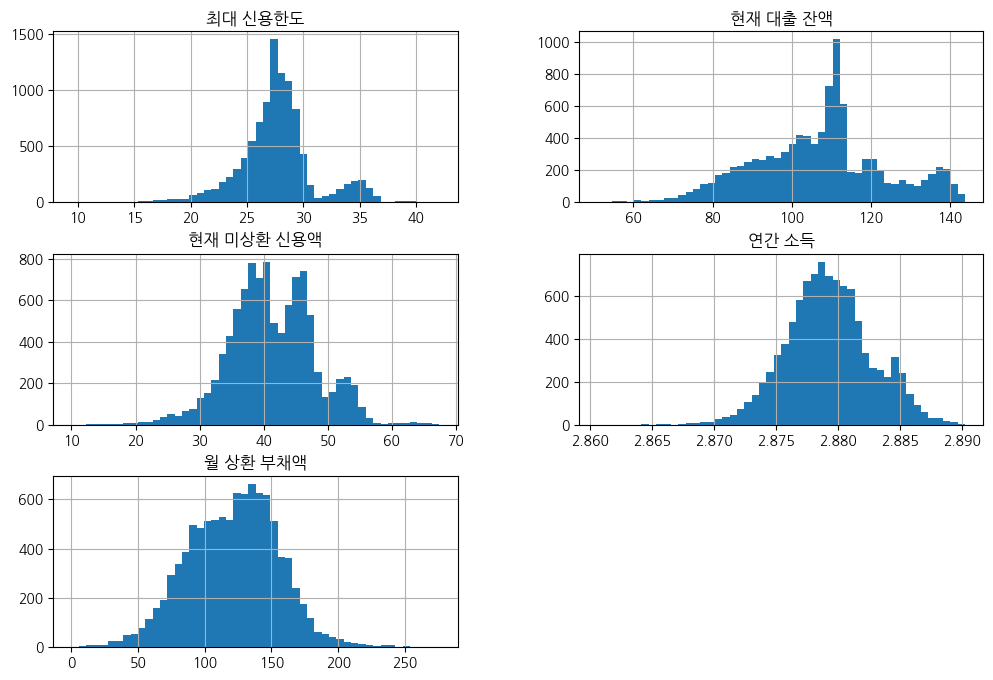

In [166]:
import matplotlib.font_manager as fm

plt.rc("font", family = "NanumGothic")

train[cols].hist(figsize = (12,8), bins = 50);

In [167]:
from scipy.stats import boxcox_normmax
box_cols = ["신용한도vs대출잔액", "신용 점수"]
for c in box_cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())

    train[c] = np.log1p(train[c])
    test[c] = np.log1p(test[c])

In [168]:
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())

In [169]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int64  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int64  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  int64  
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int64  
 11  대출 상환 기간           10000 non-null  int64  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  float64
 16  연간소득분위             1000

In [195]:
from sklearn.preprocessing import MinMaxScaler
"""
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

standard = StandardScaler()
X_scaled = standard.fit_transform(train)
test_scaled = standard.transform(test)
"""

'\nscaler = MinMaxScaler()\ntrain = scaler.fit_transform(train)\ntest = scaler.transform(test)\n\nstandard = StandardScaler()\nX_scaled = standard.fit_transform(train)\ntest_scaled = standard.transform(test)\n'

array([[<Axes: title={'center': '최대 신용한도'}>,
        <Axes: title={'center': '현재 대출 잔액'}>],
       [<Axes: title={'center': '현재 미상환 신용액'}>,
        <Axes: title={'center': '연간 소득'}>],
       [<Axes: title={'center': '월 상환 부채액'}>, <Axes: >]], dtype=object)

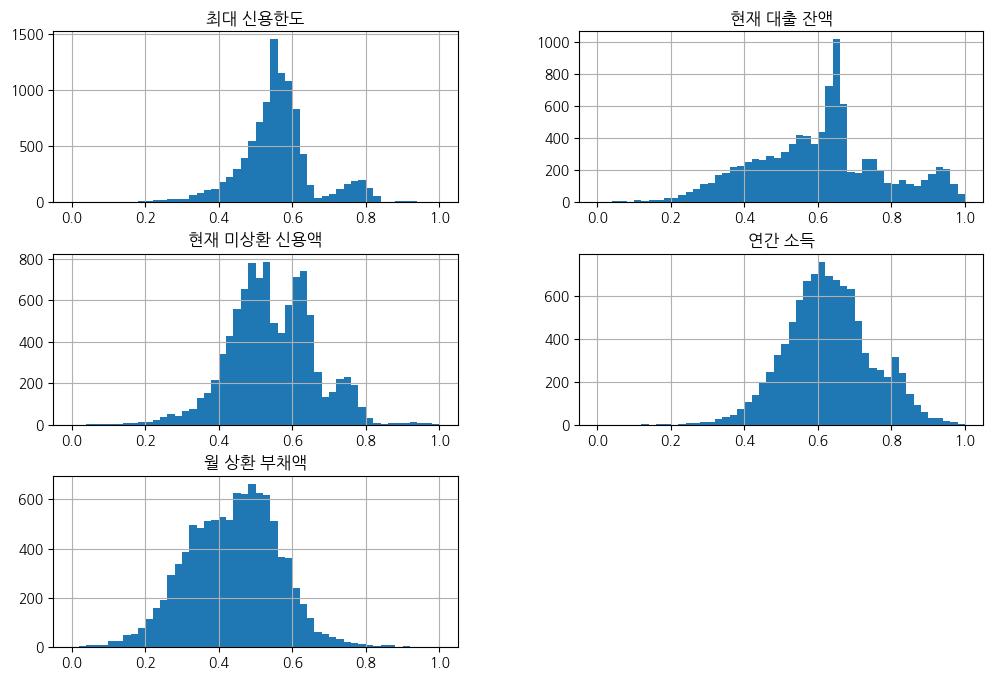

In [178]:
train[cols].hist(figsize = (12,8), bins = 50)

In [171]:
print(test_scaled)

[[-1.08977069e+00  8.90340872e+02  1.00929806e+00 ... -9.00696459e-02
  -8.41819218e-01 -2.17918350e+00]
 [ 1.14910078e+00  9.00731577e+02 -1.25268773e+00 ...  1.42374200e-01
  -9.50988434e-01 -8.62137989e-01]
 [ 1.14910078e+00  9.06260215e+02  1.00929806e+00 ... -3.55088453e-02
  -3.64890791e-01 -8.62137989e-01]
 ...
 [ 2.96650470e-02  8.99900079e+02  1.00929806e+00 ... -8.90918104e-02
   1.91737674e-01 -8.62137989e-01]
 [ 1.14910078e+00  9.23508876e+02 -1.21694836e-01 ...  1.74820757e-01
   3.33407237e-01 -8.62137989e-01]
 [-1.08977069e+00  8.97006163e+02  4.43801613e-01 ... -2.10977729e-01
   8.53178628e-01 -8.62137989e-01]]


In [198]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(train, target)

In [ ]:
all_history = []
kf = KFold(n_splits = 5, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"Fold {fold} 시작!")
    
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation= "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation= "relu"),
        tf.keras.layers.Dense(1, activation= "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = earlystop,
        verbose = 0
    )
    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold{fold} ROC-AUC score {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["val_loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

Fold 1 시작!


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold1 ROC-AUC score 0.7393
Fold 2 시작!


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold2 ROC-AUC score 0.7231
Fold 3 시작!


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold3 ROC-AUC score 0.6951
Fold 4 시작!


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [197]:
from scipy.special import inv_boxcox
pred = model.predict(test).ravel()
pred_org = inv_boxcox(pred, l2)

submission = pd.DataFrame({"UID": uid, "채무 불이행 확률": pred})
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission7.csv", index = False)
submission.head()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,UID,채무 불이행 확률
0,TEST_0000,1.913749e-07
1,TEST_0001,1.143859e-07
2,TEST_0002,1.018959e-07
3,TEST_0003,1.446181e-07
4,TEST_0004,1.295216e-07
